# Libraries/Imports

In [1]:
# Cell 1: Imports
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from textblob import TextBlob

# Loading Data

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

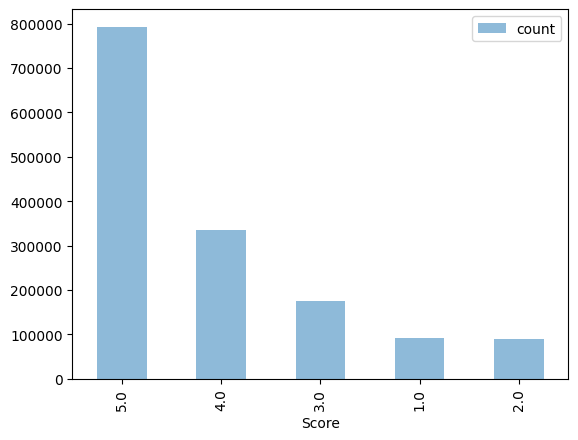


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
# Cell 2: Loading Data
trainingSet = pd.read_csv("train.csv")
testingSet = pd.read_csv("test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Feature Engineering

In [3]:
# Cell 3: Feature Engineering
def add_features_to(df):
   df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
   df['Helpfulness'] = df['Helpfulness'].fillna(0)
   df['ReviewLength'] = df['Text'].fillna('').apply(len)  
   df['Year'] = pd.to_datetime(df['Time'], unit='s').dt.year
   df['Month'] = pd.to_datetime(df['Time'], unit='s').dt.month
   df['DayOfWeek'] = pd.to_datetime(df['Time'], unit='s').dt.dayofweek
   df['MeanRatingForMovie'] = df.groupby('ProductId')['Score'].transform('mean')
   df['SummarySentiment'] = df['Summary'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity)
   df['TextSentiment'] = df['Text'].fillna('').apply(lambda x: TextBlob(x).sentiment.polarity) 

   return df


if exists('X_train1.csv'):
   X_train = pd.read_csv("X_train1.csv")
if exists('X_submission1.csv'):
   X_submission = pd.read_csv("X_submission1.csv")
else:
   train = add_features_to(trainingSet)
   X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
   X_submission = X_submission.drop(columns=['Score_x'])
   X_submission = X_submission.rename(columns={'Score_y': 'Score'})
   X_train = train[train['Score'].notnull()]
   X_submission.to_csv("X_submission1.csv", index=False)
   X_train.to_csv("X_train1.csv", index=False)

# TF-IDF and LSA Feature Extraction

In [4]:
# Cell 4: TF-IDF and LSA Feature Extraction (BEFORE splitting into train/test sets)

tfidf = TfidfVectorizer(max_features=15000)

tfidf_matrix_train = tfidf.fit_transform(X_train['Text'].fillna(''))

tfidf_matrix_submission = tfidf.transform(X_submission['Text'].fillna(''))

lsa = TruncatedSVD(n_components=100, random_state=42)

lsa_features_train = lsa.fit_transform(tfidf_matrix_train)
lsa_features_submission = lsa.transform(tfidf_matrix_submission)

lsa_train_df = pd.DataFrame(lsa_features_train, columns=[f'LSA_{i}' for i in range(lsa_features_train.shape[1])], index=X_train.index)
lsa_submission_df = pd.DataFrame(lsa_features_submission, columns=[f'LSA_{i}' for i in range(lsa_features_submission.shape[1])], index=X_submission.index)

X_train = pd.concat([X_train, lsa_train_df], axis=1)
X_submission = pd.concat([X_submission, lsa_submission_df], axis=1)


# Train/Test Split

In [5]:
# Cell 5: Train/Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
   X_train.drop(columns=['Score']),
   X_train['Score'],
   test_size=1/4.0,
   random_state=0
)

# Selecting Features for Model

In [6]:
# Cell 6: Enhanced Feature Selection for Model
from sklearn.preprocessing import StandardScaler

base_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Helpfulness', 'ReviewLength', 'MeanRatingForMovie', 'SummarySentiment', 'TextSentiment']
lsa_features = [f'LSA_{i}' for i in range(100)]
selected_features = base_features + lsa_features

X_train['contains_excellent'] = X_train['Text'].str.contains('excellent', case=False, na=False).astype(int)
X_train['contains_terrible'] = X_train['Text'].str.contains('terrible', case=False, na=False).astype(int)
X_test['contains_excellent'] = X_test['Text'].str.contains('excellent', case=False, na=False).astype(int)
X_test['contains_terrible'] = X_test['Text'].str.contains('terrible', case=False, na=False).astype(int)
X_submission['contains_excellent'] = X_submission['Text'].str.contains('excellent', case=False, na=False).astype(int)
X_submission['contains_terrible'] = X_submission['Text'].str.contains('terrible', case=False, na=False).astype(int)

selected_features += ['contains_excellent', 'contains_terrible']

scaler = StandardScaler()
X_train_scaled = X_train[selected_features].copy()
X_test_scaled = X_test[selected_features].copy()
X_submission_scaled = X_submission[selected_features].copy()


X_train_scaled[base_features] = scaler.fit_transform(X_train_scaled[base_features])
X_test_scaled[base_features] = scaler.transform(X_test_scaled[base_features])
X_submission_scaled[base_features] = scaler.transform(X_submission_scaled[base_features])

X_train_select = X_train_scaled
X_test_select = X_test_scaled
X_submission_select = X_submission_scaled




# Adjusted SMOTE

In [7]:
# Cell 7: Further Refined Borderline SMOTE Strategy
from imblearn.over_sampling import BorderlineSMOTE

class_counts = Y_train.value_counts()
min_class_count = class_counts.min()

sampling_strategy = {class_label: max(class_counts[class_label], int(min_class_count * 1.2)) for class_label in class_counts.index}

oversample = BorderlineSMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=3)
X_train_balanced, Y_train_balanced = oversample.fit_resample(X_train_select, Y_train)

print(Y_train_balanced.value_counts())



Score
5.0    595120
4.0    251418
3.0    131911
2.0     80726
1.0     80726
Name: count, dtype: int64


# Model Training

In [8]:
# Cell 8: Model Training with XGBoost and Class Weights
from xgboost import XGBClassifier 

class_weights = {1: 1, 2: 1.001, 3: 1.12, 4: 1.215, 5: 1.07} 
sample_weights = Y_train_balanced.map(class_weights)

Y_train_balanced_shifted = Y_train_balanced.astype(int) - 1

xgb_model = XGBClassifier(
   n_estimators=200,  
   gamma=1,           
   n_jobs=-1,         
   random_state=42
)

xgb_model.fit(X_train_balanced, Y_train_balanced_shifted, sample_weight=sample_weights)

Y_test_predictions = xgb_model.predict(X_test_select) + 1

# Model Evaluation

Accuracy on testing set =  0.642418187302066


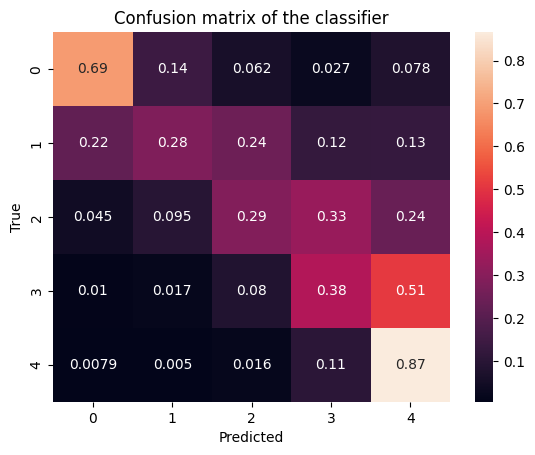

In [24]:
# Cell 9: Model Evaluation
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [10]:
# Create the submission file
X_submission['Score'] = xgb_model.predict(X_submission_select) + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)